![Rhyme](https://rhyme.com/assets/img/logo-dark.png)

In [1]:
import tensorflow as tf

# Updated for TensorFlow 2
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.16.1


# The Dataset

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


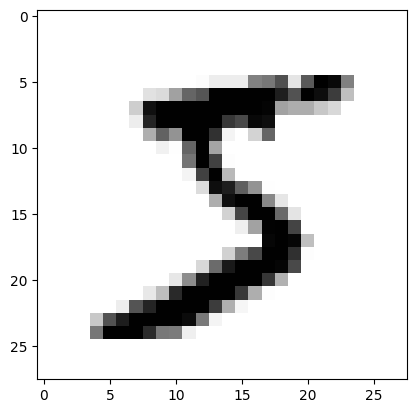

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[0], cmap = 'binary')
plt.show()

In [6]:
y_train[0]

5

In [7]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

# One Hot Encoding

We will change the way this label is represented from a class name or number to a list of all possible classes with all the classes set to 0 except the one which this example belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] |
| 7 | [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] |
| 1 | [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] |


In [8]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

To make sure the encoding worked, let's check the shape of the encoded labels.

In [9]:
print('y_train shape: ', y_train_encoded.shape)
print('y_test shape: ', y_test_encoded.shape)

y_train shape:  (60000, 10)
y_test shape:  (10000, 10)


And just like before, let's also take a look at the first label and make sure that encoding is correct:

In [10]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

# Neural Networks

Consider the following graph:

![Single Neuron](images/1_2.png)

The above graph simply represents the equation:

\begin{equation}
y = w1 * x1 + w2 * x2 + w3 * x3 + b
\end{equation}

Where the `w1, w2, w3` are called the weights and `b` is an intercept term called bias. The graph above, therefore, is simply a graphical representation of a simple linear equation. The equation can also be *vectorised* like this:

\begin{equation}
y = W . X + b
\end{equation}

Where `X = [x1, x2, x3]` and `W = [w1, w2, w3].T`. The .T means *transpose*. This is because we want the dot product to give us the result we want i.e. `w1 * x1 + w2 * x2 + w3 * x3`. This gives us the vectorised version of our linear equation.

What we are trying to ask, essentially, is if given a large amount of data (pairs of X and corresponding y), can we write an algorithm to figure out the optimal values of W and b? We need to find a way for our model to find the *optimal* values for W and b and not the absolute values. Absolute values probably don't even exist given the limitations of our mathematical model since we are *assuming* a linear function for a problem where it might be a much more complex one in reality and we don't know what that function is.

By taking the observed data and a proposed model, we want to write an algorithm to learn the values for W and b which best fit the data and ultimately, by doing that, we learn an approximate function which maps the inputs to outputs of our data. This type of algorithm is called an _optimization_ algorithm and there are a few different optimization algorithms that are typically used in training neural networks.

In our problem, our examples are of shape`(60000, 28, 28)`. The first dimension is simply the number of examples we have, so each example is of the shape `(28, 28)`. If we unroll this array into a single dimension, it will become a `28 * 28 = 784` dimensional vector. Now, it can probably be modeled somewhat like a linear equation, right? Given features from `x1` to `x784`, we get an output `y`. Here, each pixel value is a feature in our examples.

![Single Neuron with 784 features](images/1_3.png)

This may actually work for really simple problems but in our case, this model will turn out to be insufficient.

Turns out, we can learn much more complex functions by simply *cascading* the linear functions one after the other. The only additional thing that a node in a neural network does (as opposed to a node in a linear equation shown above) is that an activation function is applied to each linear output. The purpose of an activation functions is to help the neural network find non-linear patterns in the data because if we just cascaded the neurons or nodes like the ones described above, even with many layers of cascaded linear functions, the result will still be a linear function which means that, after training the mode, it will learn a linear function that best fit the data. This is a problem because in many, if not most cases, the input to output map is going to be much more complex than a linear function. So, the activation gives the model more flexibility, and allows the model to be able to learn non-linear patterns.

Now, instead of setting y to a weighted sum of our input features, we can get a few hidden outputs which are weighted sums of our input features passed through an activation function and then get the weighted sums of those hidden outputs and so on. We do this a few times, and then get to our output y. This type of model gives our algorithm a much greater chance of learning a complex function.

![Neural Network with 2 hidden layers](images/1_4.png)

In the network above, we have two *hidden layers*. The first layer with all the X features is called the input layer and the output y is called the output layer. In this example, the output has only one __node__. The hidden layer can have a lot of nodes or a very few nodes depending on how complex the problem may be. Here, both the hidden layer have 2 nodes each. Each node gives the output of a linear function after the linear output passes through an activation function, and takes inputs from each node of the preceding layer. All the W's and all the b's associated with all of these functions will have to be "learned" by our algorithm as it attempts to optimize those values in order to best fit the given data. Note that the total number of learnable parameters in any layer depend on the number of nodes in that layer as well as on the number of nodes in the preceding layer. For example, learnable parameters for __hidden layer 1__ can be calculated as: (number of nodes of the layer) * (number of nodes of preceding layer) + (number of nodes of the layer). Why? The first part is obvious: if every node of a layer is connected to every node of the preceding layer, we can simply multiply the number of nodes of these two layers to get the total number of weight parameters. Also, the __bias__ from previous layer would be connected to each node in the layer as well - that gives us the second term. So, for __hidden layer 1__, we get: `2 * 2 + 2 = 6` learnable parameters.

In the hand-written digit classification problem, we will have 128 nodes for two hidden layers, we will have 10 nodes for the output layer with each node corresponding to one output class, and of course we already know that the input is a 784 dimensional vector.

# Preprocessing the Examples

We will create a Neural Network which will take 784 dimensional vectors as inputs (28 rows * 28 columns) and will output a 10 dimensional vector (For the 10 classes). We have already converted the outputs to 10 dimensional, one-hot encoded vectors. Now, let's convert the input to the required format as well. We will use numpy to easily unroll the examples from `(28, 28)` arrays to `(784, 1)` vectors.

In [11]:
import numpy as np

x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


Each element in each example is a pixel value. Let's take a look at a few values of just one example.

In [12]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


Pixel values, in this dataset, range from 0 to 255. While that's fine if we want to display our images, for our neural network to learn the weights and biases for different layers, computations will be simply much more effective and fast if we *normalized* these values. In order to normalize the data, we can calculate the mean and standard deviation for each example.

In [13]:
x_mean = np.mean(x_train_reshaped)
x_std = np.std(x_train_reshaped)

print('mean: ', x_mean)
print('std: ', x_std)

mean:  33.318421449829934
std:  78.56748998339798


Now we will normalise both the training and test set using the mean and standard deviation we just calculated. Notice that we will need to apply the same mean and standard deviation to the test set even though we did not use the test set to calculate these values.

In [14]:
epsilon = 1e-10
x_train_norm = (x_train_reshaped - x_mean)/(x_std + epsilon)
x_test_norm = (x_test_reshaped - x_mean)/(x_std + epsilon)

Note how we added a small value to our denominator. This is because, just in case if our std was close to zero, we'd get very large values as a result. In this case, that's obviously not true but we added this anyway as a good practice since this is typically done to ensure numerical stability.

We looked at some of the values for the first training example before. Let's take a look at it again, after having normalised the values.

In [15]:
print(set(x_train_norm[0]))

{-0.38589016215482896, 1.306921966983251, 1.17964285952926, 1.803310486053816, 1.6887592893452241, 2.8215433456857437, 2.719720059722551, 1.1923707702746593, 1.7396709323268205, 2.057868700961798, 2.3633385588513764, 2.096052433197995, 1.7651267538176187, 2.7960875241949457, 2.7451758812133495, 2.45243393406917, 0.02140298169794222, -0.22042732246464067, 1.2305545025108566, 0.2759611966059242, 2.210603629906587, 2.6560805059955555, 2.6051688630139593, -0.4240738943910262, 0.4668798577869107, 0.1486820891519332, 0.3905123933145161, 1.0905474843114664, -0.09314821501064967, 1.4851127174188385, 2.7579037919587486, 1.5360243604004349, 0.07231462467953861, -0.13133194724684696, 1.294194056237852, 0.03413089244334132, 1.3451056992194483, 2.274243183633583, -0.24588314395543887, 0.772349715676489, 0.75962180493109, 0.7214380726948927, 0.1995937321335296, -0.41134598364562713, 0.5687031437501034, 0.5941589652409017, 0.9378125553666773, 0.9505404661120763, 0.6068868759863008, 0.4159682148053143

# Creating a Model

We use a Sequential class defined in Keras to create our model. All the layers are going to be Dense layers. This means, like our examples above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation = 'relu', input_shape = (784,)),
    Dense(128, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

c:\Users\Piyumi Fernando\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's understand the code above. We are instantiating a Sequential model. We pass on a list of layers that we want in our model, in the order that we want them. So, we have two hidden layers with 128 nodes each and one output layer with 10 nodes. We set the input shape on the first hidden layer to correspond to the shape of a single example from our reshaped training and test sets - we know each example is a 784 dimensional vector for the 784 pixels of the images.

We have talked about each node having a weighted sum of the inputs of the preceding layer. And, before this sum is fed to the next layer's nodes, it goes through another function called an activation function. So, each node actually does two things. First step is the weighted sum, let's call it Z:

\begin{equation}
Z = W . X + b
\end{equation}

The second step in the node is the activation function output, let's call it A:

\begin{equation}
A = f(Z)
\end{equation}

There are various types of activation functions used in Neural Networks. One of the more common ones is a rectified linear unit of ReLU function. It's a pretty simple function: it's a linear function for all the positive values and is simply set to `0` for all the negative values. Something like this:

![Linear Sum and Activation Function](images/1_5.png)

Another activation function we are using is called *softmax*. This function gives us probability scores for various nodes, in this case 10 nodes of the output layer, which sum upto 1. This activation gives us the probabilities for various classes given the input. The class with the highest probability gives us our prediction.

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimasation algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, *categorical cross entropy* is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [17]:
model.compile(
    optimizer = 'sgd',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Notice how we have over 100 thousand parameters (the weights and biases) to learn even though we are using only 2 hidden layers. For deep neural networks, this value can be, and often is, in millions.

In order to get the approximation of our function, we just need to fit the model to our data. We will use only training set to do this learning and will reserve the test set for later when we want to check the accuracy of our model. This is because, if we used only one set for both training and testing, the results may be biased and our model may have simply memorized all the examples instead of learning the relationship between features and label.

# Training the Model

We are going to train the model for 5 epochs. Think of epoch like an iteration of all the examples going through the model. So, by setting the epochs to 3, we will go through all the training examples 3 times.

In [18]:
h = model.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 3
)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8171 - loss: 0.6170
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9427 - loss: 0.1979
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9573 - loss: 0.1472


In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [19]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)

print('test set accuracy: ', accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9572 - loss: 0.1454
test set accuracy:  96.21000289916992


# Predictions

In [20]:
preds = model.predict(x_test_norm)

print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
shape of preds:  (10000, 10)


We probably can't go through all the 10000 predictions for now, but we can take a look at the first few. Let's plot the first few test set images along with their predicted and actual labels and see how our trained model actually performed.

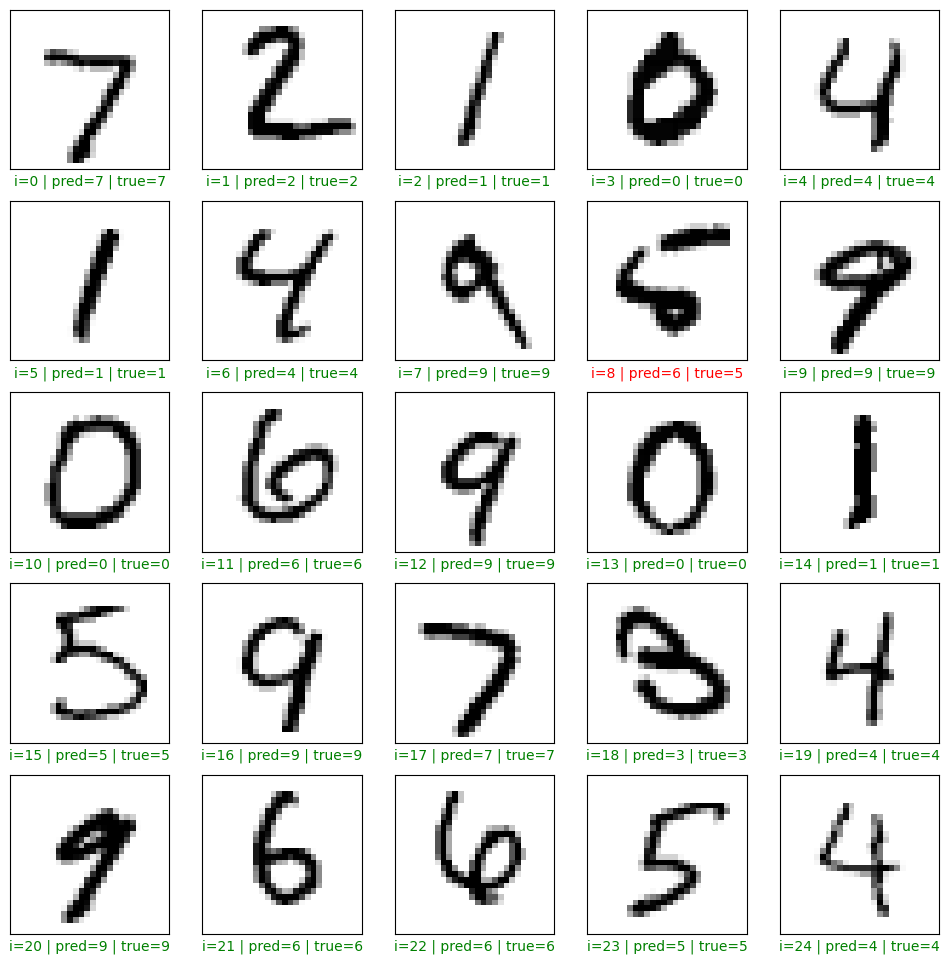

In [21]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()


It gets most of the predictions right!

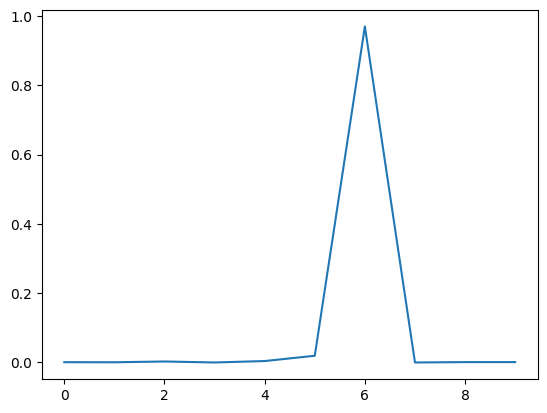

In [22]:
"""
Enter the index value in place of the value 8 below for the prediction
that you want to plot the probability scores for
"""
index = 8

plt.plot(preds[index])
plt.show()

Hopefully this gave you an insight into using Tensorflow and its Keras implementation to get started with training Neural Networks!